In [1]:
import pandas as pd
import os
import seaborn as sn
import matplotlib as mpl
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score
import pickle
sn.set_theme()
mpl.rcParams['figure.dpi'] = 300
sn.set_style("whitegrid")
import numpy as np
from matplotlib import pyplot as plt
from Bio.pairwise2 import format_alignment
from Bio import pairwise2

anno = pd.read_csv('data/scraped_annotations.csv')
binding_db = pd.read_csv('data/binding_db.csv')

C:\Users\HannesStark\Anaconda3\envs\equibind\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10,11,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\HannesStark\Anaconda3\envs\equibind\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
def realign(preds, truth, dist=2):
    # Produce different shifts for the `preds` array
    pad_preds = np.pad(preds, [(dist, dist)])
    shift_preds = []
    shift_array = np.concatenate([np.arange(-dist, 0), np.arange(1, dist + 1)])
    for ii in shift_array:
        this_preds = np.pad(pad_preds.copy(), [(0, 1)])
        shift_preds.append(this_preds[dist - ii:-dist - ii - 1] * truth)

    # Shift the `preds` array according to the maximum intersection with the truth
    EPS = 1e-8
    eps = np.zeros_like(shift_preds[0]) + EPS
    shift_preds = np.stack([eps] + shift_preds, axis=0)
    shift_idx = np.argmax(shift_preds, axis=0)
    shift_idx[shift_idx == 0] = -1
    shift_preds = np.concatenate([shift_preds, preds.reshape(1, *preds.shape)], axis=0)
    preds2 = shift_preds[shift_idx, np.arange(shift_preds.shape[1])]

    # Find the values that were shifted, and replace them by ~0
    shift_factor = np.array([shift_array[idx - 1] if idx >= 0 else 0 for idx in shift_idx])
    was_shifted = -shift_factor + np.arange(len(shift_factor))
    was_shifted = was_shifted[shift_factor != 0]
    preds2[was_shifted] = EPS

    # In case of intersection with the truth, keep the highest value to prevent bad shifts
    preds2[truth] = np.maximum(preds[truth], preds2[truth])
    return preds2


In [3]:
def binding_site_annotation(alignments_input, has_target_frame, input_sequence,misaligned_allowance):
    is_binding_site = np.zeros(len(input_sequence))
    for alignment, sequence, binding_sites in list(zip(alignments_input, has_target_frame['sequence'],
                                                       has_target_frame['Binding site residues1'])):
        if alignment['score']< len(input_sequence) * alignment_ratio or alignment['score'] < len(
                input_sequence) - misaligned_allowance: continue
        acids = []
        site_indices = []
        for site in binding_sites.split():
            acids.append(site[0])
            site_indices.append(int(site[1:]) - 1)
        reverse_indices = site_indices[::-1]
        annotated_count = 0
        to_annotate_count = 0
        target_sequence = ''
        target_sequence_annotations = ''
        annotated_sequence_annotations = ''
        annotated_sequence_annotations_manual = ''
        align_annotation_annotated_sequence = ''
        align_annotation_target = ''
        for i in range(len(is_binding_site)):
            if i in reverse_indices:
                annotated_sequence_annotations += '1'
            else:
                annotated_sequence_annotations += '0'

        for annotated, to_annotate in list(zip(alignment['seq1'], alignment['seq2'])):
            if len(reverse_indices) == 0: break
            is_binding_idx = False
            if reverse_indices[-1] == annotated_count and annotated != '-':
                reverse_indices.pop()
                is_binding_idx = True

            if to_annotate != '-':
                if is_binding_idx:
                    is_binding_site[to_annotate_count] = 1
                    target_sequence_annotations += '1'
                    align_annotation_target += '1'
                else:
                    target_sequence_annotations += '0'
                    align_annotation_target += '0'
                target_sequence += to_annotate
                to_annotate_count += 1
            else:
                align_annotation_target += '-'

            if annotated != '-':
                if is_binding_idx:
                    align_annotation_annotated_sequence += '1'
                    annotated_sequence_annotations_manual += '1'
                else:
                    align_annotation_annotated_sequence += '0'
                    annotated_sequence_annotations_manual += '0'
                annotated_count += 1
            else:
                align_annotation_annotated_sequence += '-'

        #print(align_annotation_target)
        #print(alignment['seq1'])
        #print(alignment['seq2'])
        #print(align_annotation_annotated_sequence)
        #print(target_sequence_annotations)
        #print(target_sequence)
        #print(sequence)
        #print(annotated_sequence_annotations)
        #print(annotated_sequence_annotations_manual)
        #print('\n')
    return is_binding_site

In [4]:
import os
import yaml
from zipfile import ZipFile

FILE_BEFORE = "metrics_before_finetune.yaml"
FILE_AFTER = "metrics.yaml"

def get_metrics_from_zipfile(path):
    with ZipFile(path) as zip:
        all_files = list(zip.namelist())
        metrics_before, metrics_after = {}, {}
        for file in tqdm(all_files):
            path = os.path.dirname(file)
            filename = os.path.basename(file)
            if filename == FILE_BEFORE:
                with zip.open(file) as file_yaml:
                    dic = yaml.load(file_yaml, Loader=yaml.FullLoader)
                metrics_before[path] = dic["best_epoch_metric_summaries"]["test"]
            elif filename == FILE_AFTER:
                with zip.open(file) as file_yaml:
                    dic = yaml.load(file_yaml, Loader=yaml.FullLoader)
                metrics_after[path] = dic["best_epoch_metric_summaries"]["test"]
    return metrics_before, metrics_after

In [5]:
output_name = 'images_1head'
if not os.path.exists(output_name):
    os.mkdir(output_name)
input_name = 'finetune_all_lr0.0001_loss-mse-heads-4'

In [6]:
metrics_before, metrics_after = get_metrics_from_zipfile(
    'data/binding_db_DGN_ESM_models_finetuned_finetune_all_lr0.0001_loss-mse_heads-4.zip')

100%|██████████| 17675/17675 [01:41<00:00, 173.84it/s]


In [7]:
names = os.listdir(f'data/{input_name}')
pearsonRs = []
for name in tqdm(names):
    try:
        pearsonRs.append(metrics_after[f'{input_name}/{name}/default/version_0']['pearsonr/test'])
    except:
        pearsonRs.append(0)


100%|██████████| 1502/1502 [00:00<?, ?it/s]


In [9]:

per_name_alignments = {}
for name, pearsonR in tqdm(list(zip(names, pearsonRs))):

    attention_weights_name = os.path.join('data',input_name, name, 'default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        attention_weights_name = os.path.join('data',input_name, name, 'FLAP/default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        per_name_alignments[name] =[]
        continue
    csv_input = pd.read_csv(attention_weights_name)
    csv_input = csv_input.sort_values(by=['preds-0'], ascending=False)
    #csv_input = csv_input.drop(csv_input.index[range(10,len(csv_input))])
    query_sequences = list(set(csv_input['proteins_seq'].tolist()))
    for query_idx, query_sequence in enumerate(query_sequences):
        seq_info = binding_db.loc[binding_db['BindingDB Target Chain  Sequence'] == query_sequence]
        complex_ids_repeated = seq_info['PDB ID(s) for Ligand-Target Complex'].dropna().tolist()
        complex_ids = list(set([pdbid for repeated in complex_ids_repeated for pdbid in str(repeated).split(',')]))
        if complex_ids == []: continue
        target_ids_repeated = seq_info['PDB ID(s) of Target Chain'].dropna().tolist()
        target_ids = list(set([pdbid for repeated in target_ids_repeated for pdbid in str(repeated).split(',')]))
        comp_and_target_ids = list(set(complex_ids) | set(target_ids))
        has_target = anno.loc[anno['PDBID'].isin(comp_and_target_ids)]
        has_target_by_sequence = anno.loc[anno['sequence'].isin(query_sequences)]
        sequences = has_target['sequence'].tolist()

        all_alignments = []

        for sequence in sequences:
            try:
                alignments = pairwise2.align.globalxx(query_sequence, sequence)
                all_alignments.append({'score': alignments[0].score, 'seq1': alignments[0][0], 'seq2': alignments[0][1]})
            except:
                continue
        per_name_alignments[name + 'query_idx' + str(query_idx)] =all_alignments

if not os.path.exists('data/alignments/'):
    os.mkdir('data/alignments/')
import pickle
pickle.dump(per_name_alignments,open(f'data/alignments/{input_name}.pt','wb'))


1502


100%|██████████| 1502/1502 [13:32:20<00:00, 32.45s/it]    


In [14]:
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
all_results = []
all_random_results = []
all_random_30_results = []
all_pred_results = []
all_tn_30 = []
all_fp_30 = []
all_fn_30 = []
all_tp_30 = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
top_attention_scores = 5
saved_alignments = pickle.load(open(f'data/alignments/{input_name}.pt','rb')) # for every name this has a list of aligned proteins
for name, pearsonR in tqdm(list(zip(names, pearsonRs))):
    if pearsonR < 0.82: continue

    attention_weights_name = os.path.join('data',input_name, name, 'default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        attention_weights_name = os.path.join('data',input_name, name, 'FLAP/default/version_0/attn_weights_test_head_0.csv')

    csv_input = pd.read_csv(attention_weights_name)
    csv_input = csv_input.sort_values(by=['preds-0'], ascending=False)
    #csv_input = csv_input.drop(csv_input.index[range(10,len(csv_input))])
    query_sequences = list(set(csv_input['proteins_seq'].tolist()))

    for query_idx, query_sequence in enumerate(query_sequences):
        try:
            seq_info = binding_db.loc[binding_db['BindingDB Target Chain  Sequence'] == query_sequence]
            complex_ids_repeated = seq_info['PDB ID(s) for Ligand-Target Complex'].dropna().tolist()
            complex_ids = list(set([pdbid for repeated in complex_ids_repeated for pdbid in str(repeated).split(',')]))
            if complex_ids == []: continue
            target_ids_repeated = seq_info['PDB ID(s) of Target Chain'].dropna().tolist()
            target_ids = list(set([pdbid for repeated in target_ids_repeated for pdbid in str(repeated).split(',')]))
            comp_and_target_ids = list(set(complex_ids) | set(target_ids))
            has_target = anno.loc[anno['PDBID'].isin(comp_and_target_ids)]
            has_target_by_sequence = anno.loc[anno['sequence'].isin(query_sequences)]
            sequences = has_target['sequence'].tolist()

            if name + 'query_idx' + str(query_idx) not in saved_alignments.keys():
                print('missing ', name)
                continue
            all_alignments = saved_alignments[name + 'query_idx' + str(query_idx)]
            if all_alignments == []: continue

            scores = [alignment['score'] for alignment in all_alignments]
            top3_misalginment_scores = sorted(list(set(-np.array(scores) + len(query_sequence))))[:3]
            misaligned_allowance = top3_misalginment_scores[-1]

            alignment_ratio = 0.01  # This is the percentage of a sequence that needs to be aligned to the original sequence to include its binding sites

            row = csv_input.loc[csv_input['proteins_seq'] == query_sequence]
            random_results = []
            pred_results=[]
            random30_results = []
            results= []
            most_tn_30 = []
            most_fp_30 = []
            most_fn_30 = []
            most_tp_30 = []
            most_tn = []
            most_fp = []
            most_fn = []
            most_tp = []

            attention = np.array(row.values.tolist())
            attention = attention[:, 7:len(query_sequence) + 7].astype(float)[:top_attention_scores]
            attention_mean = attention.mean(axis=0)
            attention_mean = attention_mean / attention_mean.max()
            top_prediction_idx = attention_mean.argsort()[-3:][::-1]
            top_predictions = np.zeros_like(attention_mean)
            top_predictions[np.array(top_prediction_idx)] = 1

            repeats = int(np.ceil(attention.shape[0] / 30))
            is_binding_site = binding_site_annotation(all_alignments, has_target_frame=has_target,
                                                      input_sequence=query_sequence, misaligned_allowance=misaligned_allowance)

            rand_tpr3 = 0
            n_rand = 30
            random_30 = []
            tn_30 = []
            fp_30 = []
            fn_30 = []
            tp_30 = []
            for i in range(n_rand):
                random_int_idx = np.random.randint(0, len(is_binding_site), size=3)
                random_int = np.zeros_like(is_binding_site)
                random_int[random_int_idx] = 1
                random_int_dist3 = realign(random_int,is_binding_site.astype(int), dist=3)
                random_int_dist3[random_int_dist3 < 0.01] = 0
                true_pos_random3 = precision_score(is_binding_site.astype(int), random_int_dist3.astype(int))
                rand_tpr3 += true_pos_random3
                tn, fp, fn, tp = confusion_matrix(is_binding_site.astype(int), random_int_dist3.astype(int)).ravel()
                tn_30.append(tn)
                fp_30.append(fp)
                fn_30.append(fn)
                tp_30.append(tp)
            rand_tpr3 = rand_tpr3/n_rand
            #continuous_preds_dist1 = realign(attention_mean,is_binding_site.astype(int), dist=1)
            #continuous_preds_dist2 = realign(attention_mean,is_binding_site.astype(int), dist=2)
            #continuous_preds_dist3 = realign(attention_mean,is_binding_site.astype(int), dist=3)
            #preds_dist1 = realign(top_predictions,is_binding_site.astype(int), dist=1)
            #preds_dist2 = realign(top_predictions,is_binding_site.astype(int), dist=2)
            preds_dist3 = realign(top_predictions,is_binding_site.astype(int), dist=3)
            #random_int_dist1 = realign(random_int,is_binding_site.astype(int), dist=1)
            #random_int_dist2 = realign(random_int,is_binding_site.astype(int), dist=2)

            #continuous_random = np.random.rand(len(attention_mean))
            #continuous_random = continuous_random/continuous_random.max()
            #random_cont_dist1 = realign(continuous_random,is_binding_site.astype(int), dist=1)
            #random_cont_dist2 = realign(continuous_random,is_binding_site.astype(int), dist=2)
            #random_cont_dist3 = realign(continuous_random,is_binding_site.astype(int), dist=3)
            true_pos_rate = precision_score(is_binding_site.astype(int), top_predictions.astype(int))
            tn, fp, fn, tp = confusion_matrix(is_binding_site.astype(int), preds_dist3.astype(int)).ravel()

            #true_pos_rate1 = precision_score(is_binding_site.astype(int), preds_dist1.astype(int))
            #true_pos_rate2 = precision_score(is_binding_site.astype(int), preds_dist2.astype(int))
            true_pos_rate3 = precision_score(is_binding_site.astype(int), preds_dist3.astype(int))
            #true_pos_random1 = precision_score(is_binding_site.astype(int), random_int_dist1.astype(int))
            #true_pos_random2 = precision_score(is_binding_site.astype(int), random_int_dist2.astype(int))
            random30_results.append(random_30)
            random_results.append(rand_tpr3)
            pred_results.append(true_pos_rate3)
            results.append(true_pos_rate3 - rand_tpr3)

            all_tn_30.append(tn_30)
            all_fp_30.append(fp_30)
            all_fn_30.append(fn_30)
            all_tp_30.append(tp_30)
            all_tn.append(tn)
            all_fp.append(fp)
            all_fn.append(fn)
            all_tp.append(tp)
            all_results.append(results)
            all_random_30_results.append(random30_results)
            all_pred_results.append(pred_results)
            all_random_results.append(random_results)
        except Exception as e:
            print(e)
            print('For name ', name)



  1%|          | 16/1502 [00:02<03:28,  7.12it/s]

missing  3',5'-cyclic phosphodiesterase
missing  3',5'-cyclic phosphodiesterase


  2%|▏         | 28/1502 [00:08<08:24,  2.92it/s]

missing  4-hydroxyphenylpyruvate dioxygenase


  3%|▎         | 46/1502 [00:11<03:23,  7.16it/s]

index 1058 is out of bounds for axis 0 with size 573
For name  60 kDa heat shock protein, mitochondrial


  3%|▎         | 48/1502 [00:12<08:20,  2.90it/s]

index 1065 is out of bounds for axis 0 with size 660
For name  72 kDa type IV collagenase


  3%|▎         | 50/1502 [00:14<12:34,  1.93it/s]

missing  Acetylcholinesterase
missing  Acetylcholinesterase


  4%|▍         | 65/1502 [00:20<07:49,  3.06it/s]

index 1059 is out of bounds for axis 0 with size 824
For name  ADAM17


  6%|▋         | 95/1502 [00:24<02:26,  9.62it/s]

index 483 is out of bounds for axis 0 with size 453
For name  Aldehyde dehydrogenase 3A1 (ALDH3A1)


  8%|▊         | 119/1502 [00:26<01:29, 15.38it/s]

index 536 is out of bounds for axis 0 with size 450
For name  Alpha-2A adrenergic receptor


  8%|▊         | 126/1502 [00:30<10:02,  2.28it/s]

missing  Amine oxidase, copper containing


  9%|▊         | 128/1502 [00:31<10:03,  2.28it/s]

missing  Aminopeptidase N


  9%|▉         | 133/1502 [00:34<11:40,  1.95it/s]

index 399 is out of bounds for axis 0 with size 363
For name  Angiotensin II receptor


  9%|▉         | 141/1502 [00:35<05:29,  4.13it/s]

missing  Apoptosis regulator Bcl-2


 11%|█▏        | 171/1502 [00:41<05:40,  3.91it/s]

index 783 is out of bounds for axis 0 with size 770
For name  Beta amyloid A4 protein


 12%|█▏        | 175/1502 [00:42<06:45,  3.27it/s]

index 418 is out of bounds for axis 0 with size 413
For name  Beta-2 adrenergic receptor


 12%|█▏        | 176/1502 [00:42<06:47,  3.26it/s]

index 442 is out of bounds for axis 0 with size 413
For name  Beta-2 adrenergic receptor and beta-3 adrenergic receptor


 12%|█▏        | 181/1502 [00:43<04:55,  4.48it/s]

index 334 is out of bounds for axis 0 with size 265
For name  Beta-lactamase
missing  Beta-lactamase


 12%|█▏        | 184/1502 [00:46<10:33,  2.08it/s]

index 390 is out of bounds for axis 0 with size 381
For name  Beta-lactamase


 13%|█▎        | 192/1502 [00:47<07:06,  3.07it/s]

index 783 is out of bounds for axis 0 with size 770
For name  Beta-Secretase (AA 1-460)


 13%|█▎        | 194/1502 [00:52<25:51,  1.19s/it]

missing  Beta-secretase 1


 13%|█▎        | 199/1502 [00:53<11:06,  1.96it/s]

missing  Beta-secretase 2


 14%|█▍        | 217/1502 [00:56<03:02,  7.06it/s]

index 127 is out of bounds for axis 0 with size 127
For name  BRD4 BD1 (aa 42-168)


 15%|█▍        | 218/1502 [00:56<04:04,  5.26it/s]

index 127 is out of bounds for axis 0 with size 127
For name  BRD4-BD1
index 103 is out of bounds for axis 0 with size 73
For name  BRD4-BD1


 15%|█▍        | 219/1502 [00:56<04:43,  4.52it/s]

missing  BRD4-BD2


 16%|█▌        | 233/1502 [00:58<02:51,  7.41it/s]

index 75 is out of bounds for axis 0 with size 73
For name  Bromodomain-containing protein 4 Bromo 2 domain(BRD4 BD2)


 18%|█▊        | 274/1502 [01:05<02:44,  7.47it/s]

index 578 is out of bounds for axis 0 with size 473
For name  Cannabinoid receptor 1


 18%|█▊        | 276/1502 [01:08<07:38,  2.68it/s]

missing  Cannabinoid receptor 2


 19%|█▉        | 282/1502 [01:13<15:04,  1.35it/s]

index 2319 is out of bounds for axis 0 with size 459
For name  Carbonic anhydrases; II & IX


 20%|██        | 303/1502 [01:19<05:22,  3.72it/s]

missing  Cathepsin A (CTSA)


 21%|██        | 316/1502 [01:25<06:16,  3.15it/s]

index 633 is out of bounds for axis 0 with size 473
For name  Cdc25C


 22%|██▏       | 336/1502 [01:28<05:17,  3.68it/s]

missing  Cholecystokinin receptor


 24%|██▎       | 354/1502 [01:39<10:59,  1.74it/s]

index 508 is out of bounds for axis 0 with size 471
For name  Collagenase 3


 24%|██▎       | 356/1502 [01:39<08:05,  2.36it/s]

index 750 is out of bounds for axis 0 with size 688
For name  Complement C1s


 24%|██▍       | 363/1502 [01:40<03:59,  4.75it/s]

index 804 is out of bounds for axis 0 with size 467
For name  Cruzipain


 25%|██▍       | 373/1502 [01:44<08:11,  2.30it/s]

missing  Cyclin-Dependent Kinase 4 (CDK4)
index 749 is out of bounds for axis 0 with size 292
For name  Cyclin-Dependent Kinase 5 (CDK5)


 25%|██▌       | 380/1502 [01:47<06:17,  2.97it/s]

index 751 is out of bounds for axis 0 with size 726
For name  Cyclin-Dependent Kinase 9 (CDK9)


 26%|██▌       | 388/1502 [01:47<02:49,  6.59it/s]

index 352 is out of bounds for axis 0 with size 346
For name  CYSLTR2


 26%|██▌       | 391/1502 [01:47<02:53,  6.41it/s]

index 367 is out of bounds for axis 0 with size 337
For name  Cysteinyl leukotriene receptor
index 352 is out of bounds for axis 0 with size 346
For name  Cysteinyl leukotriene receptor
index 367 is out of bounds for axis 0 with size 337
For name  Cysteinyl leukotriene receptor 1


 28%|██▊       | 425/1502 [01:52<01:27, 12.25it/s]

missing  Cytosolic phospholipase A2


 29%|██▉       | 433/1502 [01:54<02:52,  6.18it/s]

missing  D-amino-acid oxidase


 29%|██▉       | 435/1502 [01:54<02:45,  6.45it/s]

index 314 is out of bounds for axis 0 with size 259
For name  DCN1-like protein 1


 30%|██▉       | 448/1502 [01:56<02:38,  6.66it/s]

missing  Dihydrofolate Reductase (DHFR)


 30%|██▉       | 450/1502 [01:57<03:46,  4.64it/s]

missing  Dihydroorotate Dehydrogenase (DHODH)


 30%|███       | 451/1502 [01:59<06:44,  2.60it/s]

missing  Dihydroorotate Dehydrogenase (DHODH)


 31%|███       | 459/1502 [02:05<13:29,  1.29it/s]

index 508 is out of bounds for axis 0 with size 492
For name  Dipeptidyl peptidase II and dipeptidyl peptidase IV (DPP2 and DPP4)


 31%|███       | 462/1502 [02:09<14:36,  1.19it/s]

index 942 is out of bounds for axis 0 with size 855
For name  Discoidin domain-containing receptor 2


 31%|███▏      | 471/1502 [02:12<08:21,  2.06it/s]

missing  DNA polymerase beta


 32%|███▏      | 474/1502 [02:13<06:31,  2.63it/s]

missing  DNA topoisomerase 1


 32%|███▏      | 478/1502 [02:14<05:57,  2.86it/s]

missing  Dopamine beta-hydroxylase


 32%|███▏      | 484/1502 [02:15<03:39,  4.64it/s]

index 671 is out of bounds for axis 0 with size 444
For name  Dopamine D2 receptor and Serotonin 2a receptor (D2 and 5HT2a)


 32%|███▏      | 485/1502 [02:16<03:49,  4.43it/s]

index 757 is out of bounds for axis 0 with size 444
For name  DRD2


 32%|███▏      | 488/1502 [02:16<03:12,  5.27it/s]

missing  Dual specificity phosphatase Cdc25B


 33%|███▎      | 490/1502 [02:17<03:36,  4.67it/s]

index 504 is out of bounds for axis 0 with size 499
For name  Dual specificity protein kinase CLK2


 33%|███▎      | 492/1502 [02:17<03:54,  4.32it/s]

index 506 is out of bounds for axis 0 with size 481
For name  Dual specificity protein kinase CLK4


 33%|███▎      | 497/1502 [02:19<03:45,  4.45it/s]

index 943 is out of bounds for axis 0 with size 857
For name  Dual specificity protein kinase TTK


 34%|███▍      | 507/1502 [02:23<06:57,  2.38it/s]

index 711 is out of bounds for axis 0 with size 491
For name  E3 ubiquitin-protein ligase Mdm2


 34%|███▍      | 514/1502 [02:25<06:12,  2.65it/s]

missing  Egl nine homolog 1


 34%|███▍      | 516/1502 [02:26<05:07,  3.20it/s]

index 434 is out of bounds for axis 0 with size 407
For name  Egl nine homolog 2


 35%|███▌      | 531/1502 [02:27<02:26,  6.64it/s]

missing  Enoyl-ACP Reductase (FabI)


 36%|███▋      | 545/1502 [02:29<01:36,  9.87it/s]

missing  Estradiol 17-beta-dehydrogenase 1


 36%|███▋      | 548/1502 [02:30<03:06,  5.12it/s]

index 750 is out of bounds for axis 0 with size 530
For name  Estradiol receptor beta (ER&#946;)
index 728 is out of bounds for axis 0 with size 595
For name  Estrogen receptor


 37%|███▋      | 560/1502 [02:33<03:24,  4.61it/s]

index 626 is out of bounds for axis 0 with size 524
For name  Excitatory amino acid transporter 3


 37%|███▋      | 562/1502 [02:34<03:22,  4.65it/s]

index 1036 is out of bounds for axis 0 with size 746
For name  EZH2(Y641F)


 38%|███▊      | 569/1502 [02:35<02:35,  5.98it/s]

index 136 is out of bounds for axis 0 with size 135
For name  Fatty acid-binding protein 5 (FABP5)


 38%|███▊      | 573/1502 [02:40<10:48,  1.43it/s]

index 1027 is out of bounds for axis 0 with size 822
For name  Fibroblast growth factor receptor 1


 38%|███▊      | 574/1502 [02:41<13:09,  1.18it/s]

index 930 is out of bounds for axis 0 with size 821
For name  Fibroblast growth factor receptor 2


 38%|███▊      | 575/1502 [02:42<11:49,  1.31it/s]

index 883 is out of bounds for axis 0 with size 806
For name  Fibroblast growth factor receptor 3


 38%|███▊      | 577/1502 [02:43<11:02,  1.40it/s]

index 828 is out of bounds for axis 0 with size 802
For name  Fibroblast growth factor receptor 4


 41%|████▏     | 622/1502 [02:47<01:02, 14.07it/s]

missing  Glucagon-like peptide 1 receptor


 46%|████▋     | 695/1502 [02:57<00:40, 19.72it/s]

missing  Heat shock protein HSP 90-alpha


 48%|████▊     | 722/1502 [03:08<03:36,  3.60it/s]

index 188 is out of bounds for axis 0 with size 99
For name  HIV-1 protease


 48%|████▊     | 723/1502 [03:09<05:27,  2.38it/s]

missing  HIV-1 protease


 49%|████▉     | 735/1502 [03:12<03:51,  3.32it/s]

index 1151 is out of bounds for axis 0 with size 288
For name  Human immunodeficiency virus type 1 integrase


 49%|████▉     | 736/1502 [03:13<03:56,  3.24it/s]

index 126 is out of bounds for axis 0 with size 99
For name  Human immunodeficiency virus type 1 protease


 49%|████▉     | 743/1502 [03:14<02:54,  4.36it/s]

index 434 is out of bounds for axis 0 with size 407
For name  Hypoxia-inducible factor prolyl hydroxylase


 50%|█████     | 756/1502 [03:16<01:49,  6.80it/s]

index 369 is out of bounds for axis 0 with size 331
For name  Induced myeloid leukemia cell differentiation protein Mcl-1 homolog


 50%|█████     | 757/1502 [03:16<02:21,  5.28it/s]

index 946 is out of bounds for axis 0 with size 745
For name  Inhibitor of nuclear factor kappa-B kinase subunit alpha


 50%|█████     | 758/1502 [03:17<02:49,  4.38it/s]

missing  Inhibitor of nuclear factor kappa-B kinase subunit beta


 51%|█████     | 763/1502 [03:17<01:52,  6.55it/s]

missing  Integrase


 51%|█████     | 768/1502 [03:18<01:32,  7.93it/s]

index 918 is out of bounds for axis 0 with size 712
For name  Interleukin-1 receptor-associated kinase 1


 53%|█████▎    | 794/1502 [03:24<02:32,  4.65it/s]

index 479 is out of bounds for axis 0 with size 293
For name  Kallikrein 5


 55%|█████▍    | 824/1502 [03:31<02:17,  4.94it/s]

index 464 is out of bounds for axis 0 with size 464
For name  Lipoamide Dehydrogenase (Lpd)
index 719 is out of bounds for axis 0 with size 447
For name  Liver X receptor (LXR alpha AND LXR beta)


 56%|█████▌    | 838/1502 [03:32<01:25,  7.80it/s]

missing  Lysine-specific histone demethylase 1A


 57%|█████▋    | 852/1502 [03:33<00:54, 11.88it/s]

index 597 is out of bounds for axis 0 with size 334
For name  Malate dehydrogenase cytoplasmic
index 1061 is out of bounds for axis 0 with size 334
For name  Malate dehydrogenase cytoplasmic


 57%|█████▋    | 854/1502 [03:33<00:58, 11.07it/s]

index 370 is out of bounds for axis 0 with size 338
For name  Malate Dehydrogenase, mitochondrial


 58%|█████▊    | 869/1502 [03:36<01:13,  8.64it/s]

index 508 is out of bounds for axis 0 with size 471
For name  Matrix metalloproteinase (1 and 13)


 58%|█████▊    | 870/1502 [03:36<01:23,  7.57it/s]

index 690 is out of bounds for axis 0 with size 477
For name  Matrix metalloproteinase (2 and 3)


 58%|█████▊    | 875/1502 [03:36<01:26,  7.22it/s]

index 582 is out of bounds for axis 0 with size 470
For name  Matrix metalloproteinase-12 (MMP12)


 58%|█████▊    | 877/1502 [03:37<02:10,  4.78it/s]

index 941 is out of bounds for axis 0 with size 267
For name  Matrix metalloproteinase-7 (MMP7)


 58%|█████▊    | 878/1502 [03:38<02:32,  4.08it/s]

index 514 is out of bounds for axis 0 with size 467
For name  Matrix Metalloproteinase-8 (MMP-8)


 59%|█████▊    | 882/1502 [03:40<03:39,  2.83it/s]

index 418 is out of bounds for axis 0 with size 350
For name  MCL1-BAK1 complex


 59%|█████▉    | 892/1502 [03:41<01:17,  7.84it/s]

index 351 is out of bounds for axis 0 with size 332
For name  Melanocortin receptor 4


 61%|██████▏   | 922/1502 [03:49<01:49,  5.31it/s]

index 2009 is out of bounds for axis 0 with size 606
For name  Mitogen-activated protein kinase kinase kinase 7


 61%|██████▏   | 923/1502 [03:50<01:59,  4.83it/s]

index 2009 is out of bounds for axis 0 with size 606
For name  Mitogen-activated protein kinase kinase kinase 7 interacting protein 1


 65%|██████▍   | 970/1502 [03:58<01:05,  8.07it/s]

index 408 is out of bounds for axis 0 with size 351
For name  N-formyl peptide receptor 2


 65%|██████▌   | 983/1502 [04:02<02:03,  4.20it/s]

missing  Neprilysin


 67%|██████▋   | 999/1502 [04:11<02:13,  3.78it/s]

index 391 is out of bounds for axis 0 with size 384
For name  Neuropeptide Y receptor type 1


 67%|██████▋   | 1005/1502 [04:12<01:28,  5.61it/s]

index 986 is out of bounds for axis 0 with size 822
For name  Neurotrophic tyrosine kinase receptor
index 965 is out of bounds for axis 0 with size 839
For name  Neurotrophic tyrosine kinase receptor


 68%|██████▊   | 1026/1502 [04:16<01:12,  6.57it/s]

missing  Nuclear receptor ROR-beta


 69%|██████▉   | 1033/1502 [04:17<00:50,  9.36it/s]

index 406 is out of bounds for axis 0 with size 372
For name  Opioid receptors; mu & delta


 69%|██████▉   | 1039/1502 [04:22<02:53,  2.66it/s]

index 424 is out of bounds for axis 0 with size 389
For name  Oxytocin receptor


 70%|███████   | 1055/1502 [04:25<01:29,  4.98it/s]

missing  Pancreatic alpha-amylase


 70%|███████   | 1056/1502 [04:25<01:46,  4.17it/s]

index 504 is out of bounds for axis 0 with size 269
For name  Pancreatic elastase


 71%|███████   | 1069/1502 [04:27<01:06,  6.56it/s]

index 152 is out of bounds for axis 0 with size 150
For name  Peptide deformylase


 72%|███████▏  | 1085/1502 [04:33<02:36,  2.66it/s]

index 926 is out of bounds for axis 0 with size 728
For name  Phosphatidylinositol 3-kinase regulatory subunit beta


 73%|███████▎  | 1094/1502 [04:35<01:35,  4.26it/s]

missing  Phosphodiesterase 1


 73%|███████▎  | 1100/1502 [04:37<02:00,  3.34it/s]

missing  Phosphodiesterase 4A


 74%|███████▎  | 1104/1502 [04:38<02:21,  2.81it/s]

missing  Phosphodiesterase 5A


 74%|███████▍  | 1113/1502 [04:42<02:24,  2.69it/s]

index 988 is out of bounds for axis 0 with size 724
For name  Phosphoinositide 3-Kinase (PI3K), delta


 74%|███████▍  | 1114/1502 [04:42<02:39,  2.44it/s]

index 160 is out of bounds for axis 0 with size 148
For name  Phospholipase A2


 75%|███████▍  | 1125/1502 [04:45<02:00,  3.13it/s]

missing  Plasma kallikrein


 76%|███████▌  | 1144/1502 [04:48<00:55,  6.42it/s]

index 493 is out of bounds for axis 0 with size 253
For name  Prion protein


 78%|███████▊  | 1169/1502 [04:52<00:38,  8.57it/s]

missing  Protease


 78%|███████▊  | 1172/1502 [04:53<01:04,  5.16it/s]

index 1038 is out of bounds for axis 0 with size 201
For name  Proteasome Macropain subunit


 78%|███████▊  | 1176/1502 [04:54<01:01,  5.31it/s]

index 621 is out of bounds for axis 0 with size 531
For name  Protein arginine methyltransferase 3 (PRMT3)


 78%|███████▊  | 1177/1502 [04:54<01:21,  3.97it/s]

index 621 is out of bounds for axis 0 with size 531
For name  Protein arginine N-methyltransferase 3


 79%|███████▊  | 1182/1502 [04:55<01:04,  4.93it/s]

missing  Protein Farnesyltransferase (PFT)


 80%|███████▉  | 1195/1502 [04:58<01:05,  4.70it/s]

index 745 is out of bounds for axis 0 with size 697
For name  Protein kinase C, gamma


 80%|████████  | 1209/1502 [05:00<00:39,  7.40it/s]

index 243 is out of bounds for axis 0 with size 173
For name  Protein-tyrosine phosphatase 4A3
missing  Proto-oncogene tyrosine-protein kinase Src


 83%|████████▎ | 1249/1502 [05:06<00:37,  6.68it/s]

index 268 is out of bounds for axis 0 with size 259
For name  Reverse transcriptase


 83%|████████▎ | 1253/1502 [05:06<00:37,  6.64it/s]

missing  Ribosomal protein S6 kinase (P70S6K)


 84%|████████▍ | 1258/1502 [05:07<00:41,  5.83it/s]

index 887 is out of bounds for axis 0 with size 740
For name  Ribosomal protein S6 kinase alpha-3


 85%|████████▍ | 1270/1502 [05:09<00:38,  6.08it/s]

missing  Selectin E


 85%|████████▍ | 1275/1502 [05:09<00:22,  9.96it/s]

missing  Serotonin (5-HT) receptor


 85%|████████▌ | 1277/1502 [05:11<01:21,  2.75it/s]

missing  Serotonin (5-HT) receptor


 86%|████████▌ | 1286/1502 [05:13<00:46,  4.60it/s]

missing  Sialidase


 88%|████████▊ | 1316/1502 [05:18<00:35,  5.28it/s]

missing  Sorbitol dehydrogenase


 88%|████████▊ | 1319/1502 [05:19<00:35,  5.18it/s]

missing  Sphingosine 1-phosphate receptor


 89%|████████▊ | 1332/1502 [05:20<00:18,  9.38it/s]

missing  SRC


 89%|████████▉ | 1342/1502 [05:21<00:18,  8.70it/s]

index 690 is out of bounds for axis 0 with size 477
For name  Stromelysin-1


 90%|████████▉ | 1347/1502 [05:22<00:18,  8.36it/s]

index 693 is out of bounds for axis 0 with size 640
For name  SUMO-activating enzyme subunit 2 (SAE2)


 91%|█████████ | 1369/1502 [05:24<00:11, 11.27it/s]

index 773 is out of bounds for axis 0 with size 625
For name  Thrombin
index 629 is out of bounds for axis 0 with size 622
For name  Thrombin and coagulation factor X


 91%|█████████▏| 1371/1502 [05:27<00:43,  3.04it/s]

index 512 is out of bounds for axis 0 with size 488
For name  Thrombin and coagulation factor X
missing  Thymidine kinase


 92%|█████████▏| 1377/1502 [05:29<00:40,  3.07it/s]

missing  Thymidine kinase


 92%|█████████▏| 1379/1502 [05:30<00:57,  2.13it/s]

missing  Thymidylate synthase


 93%|█████████▎| 1396/1502 [05:33<00:12,  8.69it/s]

index 719 is out of bounds for axis 0 with size 562
For name  Tissue-type plasminogen activator


 94%|█████████▍| 1410/1502 [05:35<00:11,  8.24it/s]

index 440 is out of bounds for axis 0 with size 246
For name  Trypsin
missing  Trypsin


 94%|█████████▍| 1414/1502 [05:37<00:19,  4.43it/s]

index 1248 is out of bounds for axis 0 with size 247
For name  Trypsin-1


 94%|█████████▍| 1418/1502 [05:37<00:17,  4.79it/s]

missing  Tryptophan 5-hydroxylase 2


 95%|█████████▌| 1434/1502 [05:44<00:38,  1.77it/s]

missing  Tyrosine-protein kinase BTK


 96%|█████████▌| 1436/1502 [05:44<00:33,  1.94it/s]

index 460 is out of bounds for axis 0 with size 450
For name  Tyrosine-protein kinase CSK


 96%|█████████▌| 1443/1502 [05:46<00:18,  3.22it/s]

missing  Tyrosine-protein kinase JAK2


 96%|█████████▋| 1449/1502 [05:49<00:22,  2.39it/s]

index 1010 is out of bounds for axis 0 with size 999
For name  Tyrosine-protein kinase Mer


 97%|█████████▋| 1450/1502 [05:51<00:35,  1.47it/s]

index 1008 is out of bounds for axis 0 with size 993
For name  Tyrosine-protein kinase receptor FLT3


 97%|█████████▋| 1452/1502 [05:52<00:31,  1.61it/s]

index 906 is out of bounds for axis 0 with size 890
For name  Tyrosine-protein kinase receptor TYRO3


 97%|█████████▋| 1453/1502 [05:53<00:35,  1.38it/s]

index 909 is out of bounds for axis 0 with size 894
For name  Tyrosine-protein kinase receptor UFO


 97%|█████████▋| 1461/1502 [05:55<00:12,  3.16it/s]

missing  Tyrosine-protein phosphatase non-receptor type 11


 99%|█████████▉| 1488/1502 [06:00<00:02,  4.93it/s]

missing  Vasopressin receptor


100%|██████████| 1502/1502 [06:03<00:00,  4.13it/s]


499
confusion predictions:
[[  1.5271   2.2926]
 [ 33.3487 456.3908]]
confusion random
[[  1.5625   2.315 ]
 [ 33.3133 456.3684]]


C:\Users\HannesStark\Anaconda3\envs\equibind\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

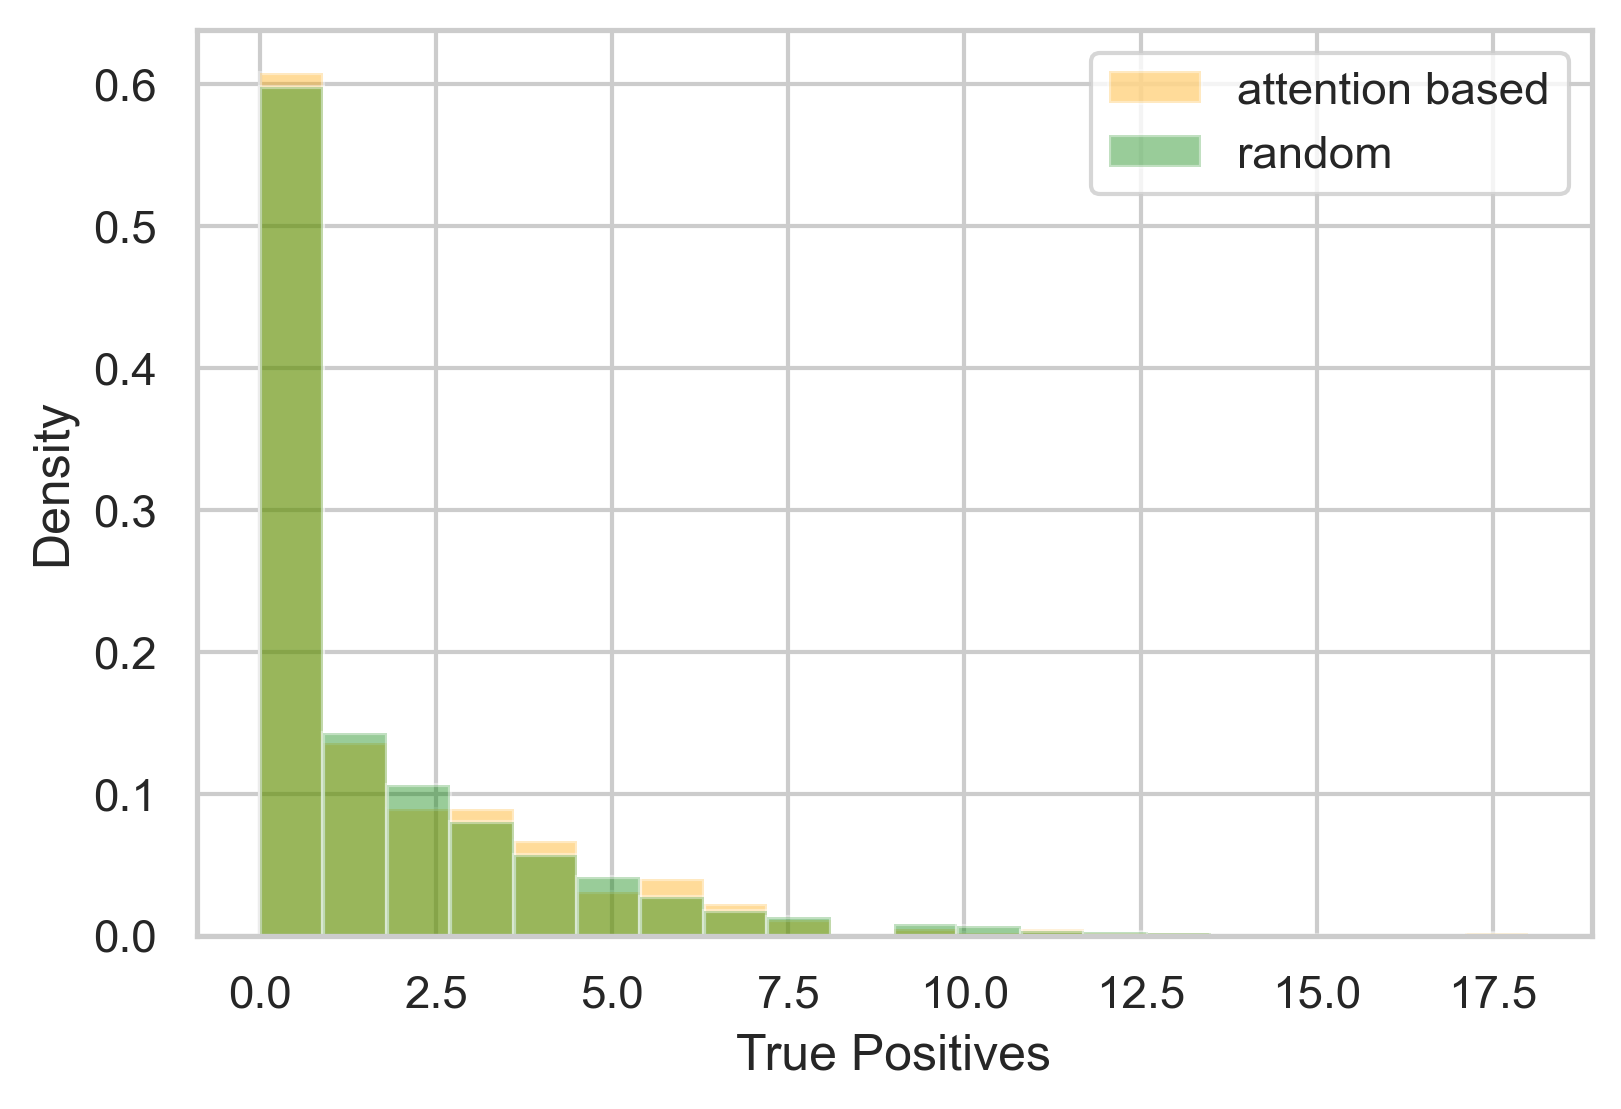

In [16]:
print(len(all_results))
all_scores_np = np.array(all_results)
all_pred = np.array(all_pred_results)
all_random = np.array(all_random_results)
all_random_30 = np.array(all_random_30_results)
all_tn_30_np = np.array(all_tn_30)
all_fp_30_np = np.array(all_fp_30)

all_fn_30_np = np.array(all_fn_30)
all_tp_30_np = np.array(all_tp_30)
all_tn_np = np.array(all_tn)
all_fp_np = np.array(all_fp)
all_fn_np = np.array(all_fn)
all_tp_np = np.array(all_tp)



np.set_printoptions(suppress=True)
print('confusion predictions:')
print(np.round(np.array([[all_tp_np.mean(), all_fp_np.mean()],
       [all_fn_np.mean(), all_tn_np.mean()]]),4))

print('confusion random')
print(np.round(np.array([[all_tp_30_np.mean(), all_fp_30_np.mean()],
       [all_fn_30_np.mean(), all_tn_30_np.mean()]]),4))

df_all_tp_np = pd.DataFrame(np.stack([all_tp_np]).T, columns=["y"])
df_all_tp_30_np = pd.DataFrame(np.stack([all_tp_30_np.flatten()]).T, columns=["y"])
sn.distplot(df_all_tp_np, kde=False , norm_hist=True,color='orange', bins=20)
sn.distplot(df_all_tp_30_np, kde=False , norm_hist=True,color='green', bins=20)
plt.legend(['attention based','random'])
plt.xlabel('True Positives')
plt.ylabel('Density')




In [ ]:

for name, pearsonR in tqdm(list(zip(names, pearsonRs))):
    if pearsonR < 0.82: continue

    attention_weights_name = os.path.join('data',input_name, name, 'default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        attention_weights_name = os.path.join('data',input_name, name, 'FLAP/default/version_0/attn_weights_test_head_0.csv')

    csv_input = pd.read_csv(attention_weights_name)
    csv_input = csv_input.sort_values(by=['preds-0'], ascending=False)
    #csv_input = csv_input.drop(csv_input.index[range(10,len(csv_input))])
    query_sequences = list(set(csv_input['proteins_seq'].tolist()))

    for query_idx, query_sequence in enumerate(query_sequences):
        try:
            seq_info = binding_db.loc[binding_db['BindingDB Target Chain  Sequence'] == query_sequence]
            complex_ids_repeated = seq_info['PDB ID(s) for Ligand-Target Complex'].dropna().tolist()
            complex_ids = list(set([pdbid for repeated in complex_ids_repeated for pdbid in str(repeated).split(',')]))
            if complex_ids == []: continue
            target_ids_repeated = seq_info['PDB ID(s) of Target Chain'].dropna().tolist()
            target_ids = list(set([pdbid for repeated in target_ids_repeated for pdbid in str(repeated).split(',')]))
            comp_and_target_ids = list(set(complex_ids) | set(target_ids))
            has_target = anno.loc[anno['PDBID'].isin(comp_and_target_ids)]
            has_target_by_sequence = anno.loc[anno['sequence'].isin(query_sequences)]
            sequences = has_target['sequence'].tolist()

            if name + 'query_idx' + str(query_idx) not in saved_alignments.keys():
                print('missing ', name)
                continue
            all_alignments = saved_alignments[name + 'query_idx' + str(query_idx)]
            if all_alignments == []: continue

            scores = [alignment['score'] for alignment in all_alignments]
            top3_misalginment_scores = sorted(list(set(-np.array(scores) + len(query_sequence))))[:3]
            misaligned_allowance = top3_misalginment_scores[-1]

            alignment_ratio = 0.01  # This is the percentage of a sequence that needs to be aligned to the original sequence to include its binding sites

            row = csv_input.loc[csv_input['proteins_seq'] == query_sequence]
            random_results = []
            pred_results=[]
            results= []
            for top_k in [3, 5, 10, 20, 30, 50]:
                attention = np.array(row.values.tolist())
                attention = attention[:, 7:len(query_sequence) + 7].astype(float)[:top_k]
                attention_mean = attention.mean(axis=0)
                attention_mean = attention_mean / attention_mean.max()
                top_prediction_idx = attention_mean.argsort()[-3:][::-1]
                top_predictions = np.zeros_like(attention_mean)
                top_predictions[np.array(top_prediction_idx)] = 1

                repeats = int(np.ceil(attention.shape[0] / 30))
                is_binding_site = binding_site_annotation(all_alignments, has_target_frame=has_target,
                                                          input_sequence=query_sequence, misaligned_allowance=misaligned_allowance)

                rand_tpr3 = 0
                n_rand = 30
                for i in range(n_rand):
                    random_int_idx = np.random.randint(0, len(is_binding_site), size=3)
                    random_int = np.zeros_like(is_binding_site)
                    random_int[random_int_idx] = 1
                    random_int_dist3 = realign(random_int,is_binding_site.astype(int), dist=3)
                    true_pos_random3 = precision_score(is_binding_site.astype(int), random_int_dist3.astype(int))
                    rand_tpr3 += true_pos_random3
                rand_tpr3 = rand_tpr3/n_rand
                random_int_idx = np.random.randint(0, len(is_binding_site), size=3)
                random_int = np.zeros_like(is_binding_site)
                random_int[random_int_idx] = 1
                random_intAvgP = average_precision_score(is_binding_site, random_int)
                random_int_true_positive_rate = precision_score(is_binding_site, random_int)
                continuous_preds_dist1 = realign(attention_mean,is_binding_site.astype(int), dist=1)
                continuous_preds_dist2 = realign(attention_mean,is_binding_site.astype(int), dist=2)
                continuous_preds_dist3 = realign(attention_mean,is_binding_site.astype(int), dist=3)
                preds_dist1 = realign(top_predictions,is_binding_site.astype(int), dist=1)
                preds_dist2 = realign(top_predictions,is_binding_site.astype(int), dist=2)
                preds_dist3 = realign(top_predictions,is_binding_site.astype(int), dist=3)
                random_int_dist1 = realign(random_int,is_binding_site.astype(int), dist=1)
                random_int_dist2 = realign(random_int,is_binding_site.astype(int), dist=2)
                random_int_dist3 = realign(random_int,is_binding_site.astype(int), dist=3)
                continuous_random = np.random.rand(len(attention_mean))
                continuous_random = continuous_random/continuous_random.max()
                random_cont_dist1 = realign(continuous_random,is_binding_site.astype(int), dist=1)
                random_cont_dist2 = realign(continuous_random,is_binding_site.astype(int), dist=2)
                random_cont_dist3 = realign(continuous_random,is_binding_site.astype(int), dist=3)
                avgROC = average_precision_score(is_binding_site, top_predictions)
                avgROC1 = average_precision_score(is_binding_site, continuous_preds_dist1)
                avgROC2 = average_precision_score(is_binding_site, continuous_preds_dist2)
                avgROC3 = average_precision_score(is_binding_site, continuous_preds_dist3)
                random_avgROC = average_precision_score(is_binding_site, continuous_random)
                random_avgROC1 = average_precision_score(is_binding_site, random_cont_dist1)
                random_avgROC2 = average_precision_score(is_binding_site, random_cont_dist2)
                random_avgROC3 = average_precision_score(is_binding_site, random_cont_dist3)
                avgP = average_precision_score(is_binding_site, top_predictions)
                avgP1 = average_precision_score(is_binding_site, continuous_preds_dist1)
                avgP2 = average_precision_score(is_binding_site, continuous_preds_dist2)
                avgP3 = average_precision_score(is_binding_site, continuous_preds_dist3)
                random_avgP = average_precision_score(is_binding_site, continuous_random)
                random_avgP1 = average_precision_score(is_binding_site, random_cont_dist1)
                random_avgP2 = average_precision_score(is_binding_site, random_cont_dist2)
                random_avgP3 = average_precision_score(is_binding_site, random_cont_dist3)
                true_pos_rate = precision_score(is_binding_site.astype(int), top_predictions.astype(int))
                true_pos_rate1 = precision_score(is_binding_site.astype(int), preds_dist1.astype(int))
                true_pos_rate2 = precision_score(is_binding_site.astype(int), preds_dist2.astype(int))
                true_pos_rate3 = precision_score(is_binding_site.astype(int), preds_dist3.astype(int))
                true_pos_random = precision_score(is_binding_site.astype(int), random_int.astype(int))
                true_pos_random1 = precision_score(is_binding_site.astype(int), random_int_dist1.astype(int))
                true_pos_random2 = precision_score(is_binding_site.astype(int), random_int_dist2.astype(int))
                true_pos_random3 = precision_score(is_binding_site.astype(int), random_int_dist3.astype(int))
                visualization = np.concatenate(
                    [np.tile(is_binding_site, (repeats, 1)), np.tile(attention_mean, (repeats, 1)), attention], axis=0)
                ax = sn.heatmap(visualization, annot=False, cmap='pink', cbar=False)
                plt.title(
                    f'name: {name} \n prot: {query_idx} pearsonR: {round(pearsonR, 2)} avgP: {round(avgP, 2)} randAvgP: {round(random_avgP, 2)} TPR: {round(true_pos_rate, 2)} randTPR: {round(true_pos_random, 2)} \n avgP1: {round(avgP1,2)} avgP2: {round(avgP2,2)} avgP3: {round(avgP3,2)} TPR1: {round(true_pos_rate1,2)} TPR2: {round(true_pos_rate2,2)} TPR3: {round(true_pos_rate3,2)} \n avgP1: {round(avgP1,2)} avgP2: {round(avgP2,2)} avgP3: {round(avgP3,2)} TPR1: {round(true_pos_rate1,2)} TPR2: {round(true_pos_rate2,2)} TPR3: {round(true_pos_rate3,2)}')
                ax.hlines([repeats * 2], *ax.get_xlim())
                plt.savefig(
                    f'{output_name}/{name}_prot{query_idx}_top{top_k}_pearsonR{round(pearsonR, 2)}_avgP{round(avgP, 2)}_tpr{round(true_pos_rate, 2)}.jpg')
                plt.show()
                plt.clf()
                #break

                random_results.append(rand_tpr3)
                pred_results.append(true_pos_rate3)
                results.append(true_pos_rate3 - rand_tpr3)
            all_results.append(results)
            all_pred_results.append(pred_results)
            all_random_results.append(random_results)
        except Exception as e:
            print(e)
            print('For name ', name)

